In [31]:
import tifffile
import pymeshlab
import numpy as np
from pathlib import Path
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform
from scipy import ndimage
import os
import igl

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from tqdm import tqdm


In [4]:
base_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06")
mesh_uv = tcmesh.ObjMesh.read_obj(str(base_path / "simple.obj"))

In [68]:
faces = np.array(mesh_uv.faces, dtype=int)[:, :, 0]
verts = np.array(mesh_uv.vertices) * 0.585

a_vert = np.argmax(verts[:, 1])
p_vert = np.argmin(verts[:, 1])


y_loc = verts[:, 1]
y_min, y_max = np.min(y_loc), np.max(y_loc)

L = 20

rescale = L / (y_max - y_min)

verts = verts * rescale
verts[:, 1] = verts[:, 1] * 0.5

y_loc = verts[:, 1]
y_min, y_max = np.min(y_loc), np.max(y_loc)
# pole_dis = np.min(np.stack([np.abs(y_loc - y_min), np.abs(y_loc - y_max)], axis=-1), axis=-1)

n = verts.shape[0]
sources = np.arange(n)

distances_to_p = np.array([igl.exact_geodesic(verts, faces, np.array([p_vert], int), np.array([s]), None,  None) for s in tqdm(sources)])
distances_to_a = np.array([igl.exact_geodesic(verts, faces, np.array([a_vert], int), np.array([s]), None,  None) for s in tqdm(sources)])
pole_dis = np.min(np.stack([distances_to_p, distances_to_a], axis=-1), axis=-1)

100%|██████████| 902/902 [00:09<00:00, 91.66it/s]


In [69]:
from robust_laplacian import mesh_laplacian
from scipy.sparse.linalg import inv

L, M = mesh_laplacian(verts, faces)

MiL = (inv(M) @ L)

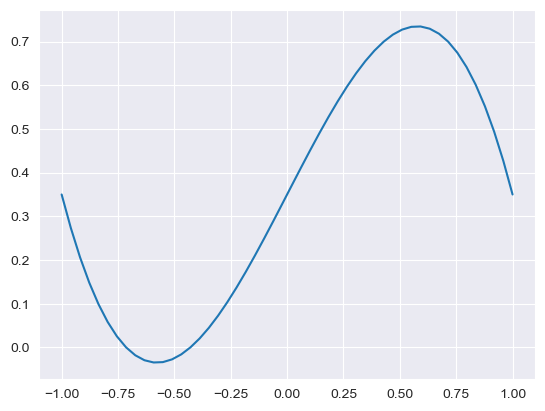

In [70]:
from scipy.integrate import solve_ivp

ic = 2*np.exp(-1/2*(pole_dis / 0.5)**2) - 0.75
lam = 0.35

def ode_fn(t, u):
    ddu = MiL @ u
    return -0.25*ddu + u - (u ** 3) + lam

u_range = np.linspace(-1, 1)
plt.plot(u_range, u_range - (u_range ** 3) + lam)
plt.show()

t_range = [0, 20]
sol = solve_ivp(ode_fn, t_range, ic, dense_output=True)

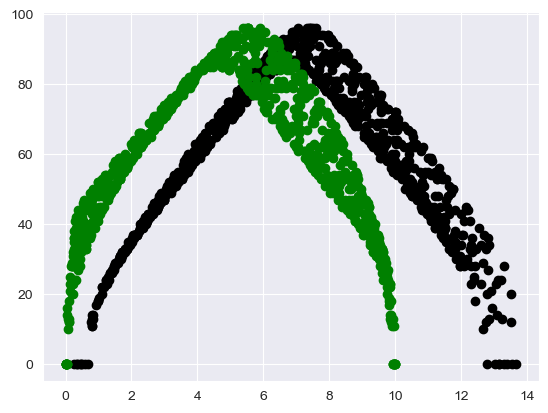

In [71]:
import napari

tdr = np.linspace(t_range[0], t_range[1], 100)
y_sol = sol.sol(tdr)

y_sol_norm = (y_sol - np.min(y_sol)) / (np.max(y_sol) - np.min(y_sol))

all_locs = []
colors = []
n = len(verts)

cmap = plt.get_cmap("viridis")

for i, t in enumerate(tdr):
    
    y_i = y_sol_norm[:, i]
  
    loc = np.hstack([np.expand_dims([i]*n, -1), verts])
    all_locs.append(loc)

    color = cmap(y_i)
    colors.append(color)

colors = np.vstack(colors)
locs = np.vstack(all_locs)

t_cross = np.argmax(y_sol > 0, axis=1)

plt.scatter(distances_to_a, t_cross, color="k")
plt.scatter(verts[:, 1], t_cross, color="g")
# plt.scatter(verts[:, 1], distances_to_a, color="r")
plt.show()


viewer = napari.Viewer()
viewer.add_points(locs, face_color=colors, size=0.2)
napari.run()

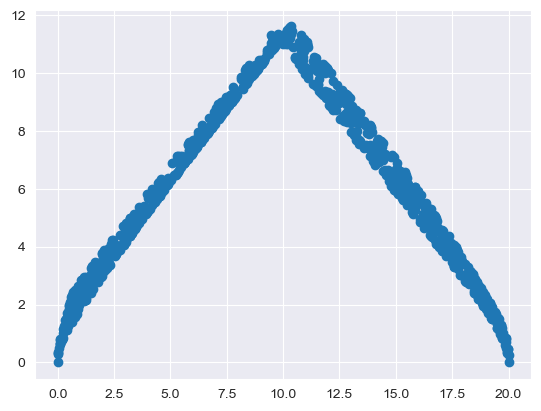

In [53]:
plt.scatter(verts[:, 1], pole_dis)
plt.show()

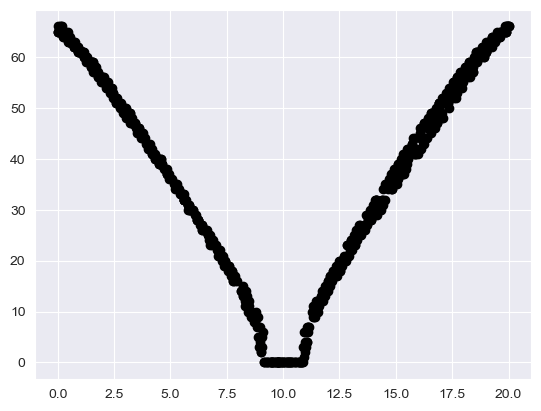

[[0.993248 0.906157 0.143936 1.      ]
 [0.267004 0.004874 0.329415 1.      ]]


In [46]:
mid_dis = np.abs(y_loc - (y_min + y_max)/2)

ic = 2 * np.exp(-1 / 2 * (mid_dis / 0.75) ** 2) - 1
lam = 0.3


def ode_fn(t, u):
    ddu = MiL @ u
    return -ddu + u - (u ** 3) + lam


t_range = [0, 20]
sol = solve_ivp(ode_fn, t_range, ic, dense_output=True)
import napari

tdr = np.linspace(t_range[0], t_range[1], 100)
y_sol = sol.sol(tdr)

y_sol_norm = (y_sol - np.min(y_sol)) / (np.max(y_sol) - np.min(y_sol))

all_locs = []
colors = []
colors2 = []
n = len(verts)

cmap = plt.get_cmap("viridis")

for i, t in enumerate(tdr):
    y_i = y_sol_norm[:, i]

    loc = np.hstack([np.expand_dims([i] * n, -1), verts])
    all_locs.append(loc)

    color = cmap(y_i)
    colors.append(color)
    colors2.append(cmap((y_i > 0.5)*1.0))
                   
colors = np.vstack(colors)
colors2 = np.vstack(colors2)
locs = np.vstack(all_locs)

t_cross = np.argmax(y_sol > 0, axis=1)

plt.scatter(verts[:, 1], t_cross, color="k")
plt.show()

print(cmap([1.0, 0.0]))

viewer = napari.Viewer()
viewer.add_points(locs, face_color=colors, size=0.2)
viewer.add_points(locs, face_color=colors2, size=0.2)
napari.run()